In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import datetime as dt

import kaggle


In [2]:
%run -i helper_functions.py

## Load data set
Uncomment the next line if you need to download the dataset directly from Kaggle

In [3]:
# kaggle.api.dataset_download_files('ethon0426/lending-club-20072020q1', path='./data', unzip=True)

In [4]:
df = pd.read_csv('./data/Loan_status_2007-2020Q3.gzip', low_memory=False)


In [5]:
total_num_records = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [6]:
# percentage of each value in loan_status
df['loan_status'].value_counts(normalize=True)


loan_status
Fully Paid                                             0.511976
Current                                                0.352425
Charged Off                                            0.123927
Late (31-120 days)                                     0.005522
In Grace Period                                        0.003428
Late (16-30 days)                                      0.000929
Issued                                                 0.000705
Does not meet the credit policy. Status:Fully Paid     0.000680
Does not meet the credit policy. Status:Charged Off    0.000260
Default                                                0.000148
Name: proportion, dtype: float64

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274), (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), (1.0, 0.6235294117647059, 0.6078431372549019), (0.8156862745098039, 0.7333333333333333, 1.0), (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), (0.9803921568627451, 0.6901960784313725, 0.8941176470588236), (0.8117647058823529, 0.8117647058823529, 0.8117647058823529), (1.0, 0.996078431372549, 0.6392156862745098), (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]


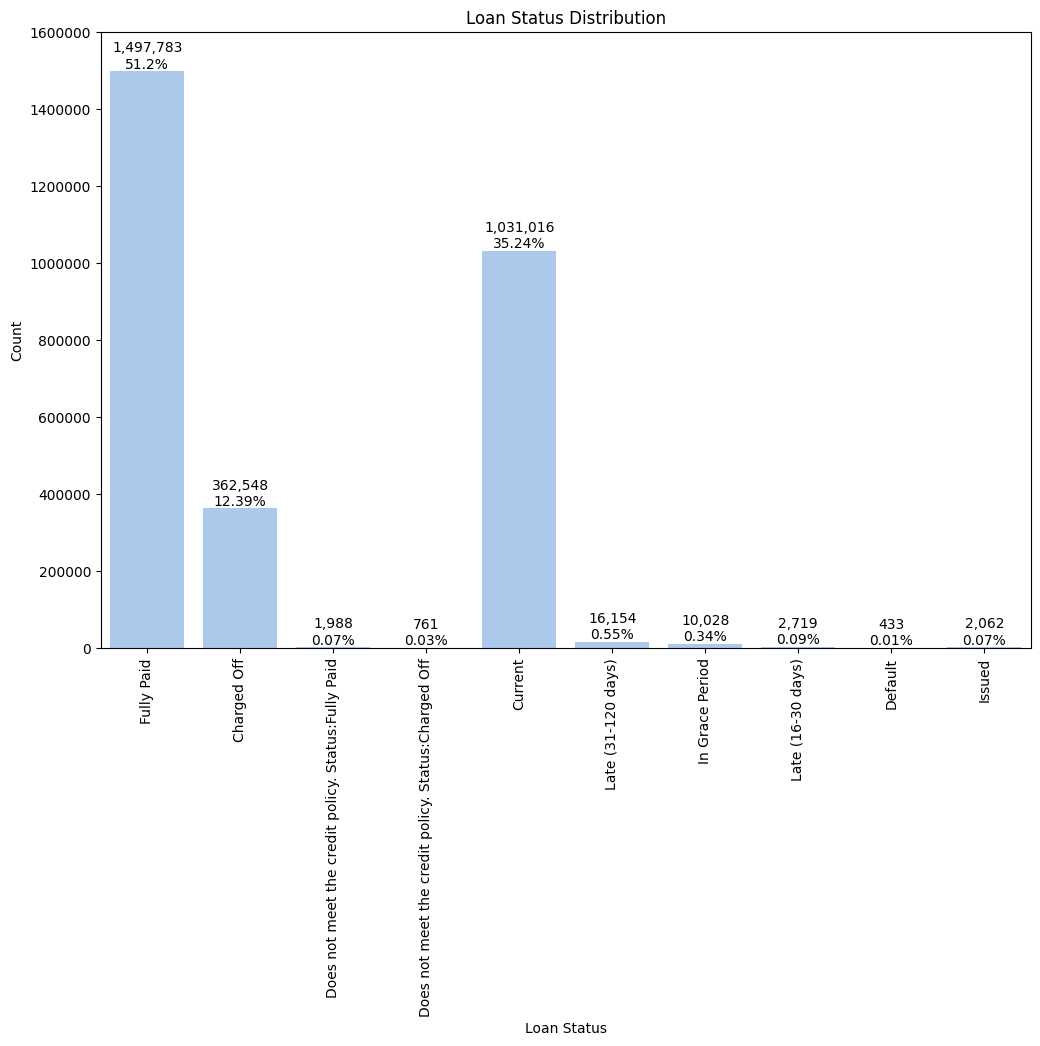

In [7]:
# Plot the distribution of loan_status
plt.figure(figsize=(12, 8))
colors = sns.color_palette('pastel')[0:len(df['loan_status'].unique())]
print(colors)
plt.gca().set_prop_cycle('color', colors)

sns.countplot(x='loan_status', data=df)
# Add title and labels
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Show y-axis in millions
plt.ticklabel_format(style='plain', axis='y')

# Set y-axis top to 1.6M
plt.ylim(0, 1600000)

# Add percentage and count on top of each bar
for i in df['loan_status'].unique():
    if i is not np.nan:
        count = df['loan_status'].value_counts()[i]
        pct_string = f'{count:,}\n{np.round(count/len(df)*100, 2)}%'
        plt.text(i, count, pct_string, ha='center', va='bottom')

plt.xticks(rotation=90)
plt.savefig('./output/loan_status_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


### Collate `loan_status`
For this effort, we primarily care about data that would help us make a prediction on whether a loan will be fully paid or not.  We will map our target variable down to two classes:
* `Fully Paid`
* `Non-Performing`:  include all 'In Grace Period', 'Default', and 'Charged Off' loans 

By assuming that `In Grace Period` and `Default` loans are non-performing, we are taking a conservative approach to further minimize risk for investors.

Loans in other statuses are dropped since their outcome has not been determined.

In [8]:
# show rows with missing values for loan_status
df[df['loan_status'].isnull()]

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
39786,39786,Loans that do not meet the credit policy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# drop rows with missing values for loan_status
df = df.dropna(subset=['loan_status'])

In [10]:
# Combine loan_status 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period', 'Charged Off', and 'Default' into 'Non-Current'
df['loan_status'] = df['loan_status'].replace(
    {
#        'Late (16-30 days)': 'Non-Current',
#        'Late (31-120 days)': 'Non-Current',
        'In Grace Period': 'Non-Performing',
        'Default': 'Non-Performing',
        'Charged Off': 'Non-Performing'
    }
)

In [11]:
loan_status_to_remove = [
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off',
    'Issued',
    'Late (16-30 days)',
    'Late (31-120 days)',
    'Current'
]

In [12]:
# Drop the rows with loan_status in loan_status_to_remove
df = df[~df['loan_status'].isin(loan_status_to_remove)]

In [13]:
# Print the number of records dropped
print(f'Number of records dropped: {total_num_records - len(df)}')

Number of records dropped: 1054701


In [14]:
df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid        0.800614
Non-Performing    0.199386
Name: proportion, dtype: float64

## Data Cleanup

### Handle features with high percentage of missing values
Let's compute percentage of missing values.  We'll remove all features with missing values above a certain threshold.

In [15]:
# Find the count and percentage of missing values
df_columns_na = pd.DataFrame({
    '% Empty': 100*df.isnull().sum()/len(df), 
    'Count': df.isnull().sum()
    })

# Determine columns with null count > 0
df_columns_na_sorted = df_columns_na[df_columns_na['Count'] > 0].sort_values('% Empty', ascending=False)
df_columns_na_sorted

,% Empty,Count
next_pymnt_d,99.440825,1860331
hardship_loan_status,99.177621,1855407
hardship_dpd,99.175804,1855373
hardship_type,99.175804,1855373
hardship_length,99.175804,1855373
...,...,...
chargeoff_within_12_mths,0.002993,56
collections_12_mths_ex_med,0.002993,56
tax_liens,0.002085,39
inq_last_6mths,0.000053,1


#### Set missing value thresholds

In [16]:
MISSING_VALUE_THRESHOLD = 40 # % threshold

In [17]:
temp = df_columns_na_sorted[df_columns_na_sorted['% Empty'] > MISSING_VALUE_THRESHOLD]
print(f'\n# of features with missing values > {MISSING_VALUE_THRESHOLD}%: {len(temp)}')
plot_dataframe_as_table_image(temp, f'features_with_over_{MISSING_VALUE_THRESHOLD}_pct_missing_values', 'Features')


# of features with missing values > 40%: 49


In [18]:
# Drop columns above a certain threshold of missing values
df_pruned = df.dropna(axis='columns', thresh=int(MISSING_VALUE_THRESHOLD/100*len(df))).copy()
df_pruned.shape

(1870792, 108)

### Compile features that we think are useful for classification 

In [19]:
features_to_keep_list = [
    'addr_state',
    'annual_inc',
    'application_type',
    'avg_cur_bal',
    'bc_util',
    'chargeoff_within_12_mths',
    'delinq_2yrs',
    'dti',
    'dti_joint',
    'emp_length',
    'emp_title',
    'fico_range_high',
    'fico_range_low',
    'grade',
    'home_ownership',
    'il_util',
    'inq_fi',
    'inq_last_12m',
    'inq_last_6mths',
    'installment',
    'int_rate',
    'issue_d',
#    'last_fico_range_high', # Not used at loan origination
#    'last_fico_range_low',  # Not used at loan origination
    'loan_amnt',
    'loan_status',
    'mths_since_last_delinq',
    'purpose',
    'revol_bal',
    'revol_util',
    'sub_grade',
    'term',
    'verification_status',
    'revol_bal_joint'
]

In [20]:
secondary_features_list = [
    'num_accts_ever_120_pd',
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'pub_rec',
    'pub_rec_bankruptcies',
]

In [21]:
# Create dataframe containing only the features in features_list
df_pruned = df_pruned.filter(items = features_to_keep_list)
df_pruned.shape

(1870792, 32)

### Data type conversion

#### Convert `issue_d` to dates for order comparison

In [22]:
# if 'issued_d' is not an object, convert it to datetime
if df_pruned['issue_d'].dtype == 'object':
    # Cast 'issue_d' to datetime
    df_pruned['issue_d'] = pd.to_datetime(df_pruned['issue_d'], format='%b-%Y')

df_pruned['issue_d'].sample(5)

792072    2018-08-01
2428689   2016-06-01
2737027   2017-03-01
468599    2017-10-01
1637192   2014-05-01
Name: issue_d, dtype: datetime64[ns]

In [23]:
# For each column in df_pruned, print the earliest 'issue_d'
for feature in df_pruned.columns:
    earliest_issue_d = df_pruned[df_pruned[feature].notnull()]['issue_d'].min()
    print(f'Earliest non-Null value for [ {feature} ]: \t\t\t{earliest_issue_d}')

Earliest non-Null value for [ addr_state ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ annual_inc ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ application_type ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ avg_cur_bal ]: 			2012-08-01 00:00:00
Earliest non-Null value for [ bc_util ]: 			2012-03-01 00:00:00
Earliest non-Null value for [ chargeoff_within_12_mths ]: 			2007-08-01 00:00:00
Earliest non-Null value for [ delinq_2yrs ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ dti ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ emp_length ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ emp_title ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ fico_range_high ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ fico_range_low ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ grade ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ home_ownership ]: 			2007-06-01 00:00:00
Earliest non-Null value for [ il_util ]: 		

Given the earliest issue dates for non-null values vary for the different features, it is likely that certain features were added over time by LendingClub.

In [24]:
CUTOFF_DATE = dt.datetime(2012,8,1)

rows_before_pruning = df_pruned.shape[0]
print(f'# of records before pruning at {CUTOFF_DATE} cut-off: {rows_before_pruning}')

# Remove loans issued prior to 2012-08-01; this is the beginning of data for avg_cur_bal
df_pruned = df_pruned[df_pruned['issue_d']>=CUTOFF_DATE]

print(f'\n# of records dropped: {rows_before_pruning - df_pruned.shape[0]}')
print(f'Remaining # of records after pruning at {CUTOFF_DATE} cut-off: {df_pruned.shape[0]}')

# of records before pruning at 2012-08-01 00:00:00 cut-off: 1870792

# of records dropped: 62936
Remaining # of records after pruning at 2012-08-01 00:00:00 cut-off: 1807856


#### Employment Titles

In [25]:
df_pruned['emp_title'] = df_pruned['emp_title'].str.replace(' ', '_')

# Combine titles that are the same but have different capitalization
df_pruned['emp_title'] = df_pruned['emp_title'].str.upper()

#### Employment Length

In [26]:
# Impute missing value for 'emp_length' based on the mode of 'emp_length'
#df.fillna({'emp_length': df['emp_length'].mode()[0]}, inplace=True)

# Instead of imputing missing values using the mode, we will fill missing values with '0'.
# emp_length of < 1 year has higher ratio of non-performing loans so we are keeping to our more conservative approach
# to minimize risk for investors

df_pruned['emp_length'] = df_pruned['emp_length'].fillna('0')
df_pruned['emp_length'] = df_pruned['emp_length'].str.replace('< 1 year', '0')
df_pruned['emp_length'] = df_pruned['emp_length'].str.replace('1 year', '1')
df_pruned['emp_length'] = df_pruned['emp_length'].str.replace('10+ years', '10')
df_pruned['emp_length'] = df_pruned['emp_length'].str.replace(' years', '') # remove ' years' from 'x years'

df_pruned['emp_length'] = df_pruned['emp_length'].astype(int)


In [27]:
df_pruned['emp_length'].unique()

array([ 4,  2, 10,  3,  5,  6,  1,  7,  0,  9,  8])

#### `int_rate`

In [28]:
print(df_pruned['int_rate'].sample(5))

if df_pruned['int_rate'].dtype == 'object':
    df_pruned['int_rate'] = df_pruned['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)
    #df_pruned['int_rate'] = df_pruned['int_rate'].str.replace('%', '').astype('float')

df_pruned['int_rate'].sample(5)

2287417      6.49%
2387493      7.89%
1521570     13.35%
153463       7.90%
1908240      9.17%
Name: int_rate, dtype: object


2161414    0.1099
1709749    0.1922
1617727    0.1757
2278057    0.1599
2532586    0.0899
Name: int_rate, dtype: float64

#### `revol_util`

In [29]:
print(df_pruned['revol_util'].sample(5))

if df_pruned['revol_util'].dtype == 'object':
    df_pruned['revol_util'] = df_pruned['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
    #df_pruned['revol_util'] = df_pruned['revol_util'].str.replace('%', '').astype('float')

df_pruned['revol_util'].sample(5)

1697145    15.7%
2715122    21.4%
153237     57.7%
1597281    88.2%
1987163    64.8%
Name: revol_util, dtype: object


2909945    0.328
1994196    0.972
2386693    0.159
1882797    0.515
263564     0.308
Name: revol_util, dtype: float64

#### `term`

In [30]:
df_pruned['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [31]:
# Remove string characters in 'term' column and convert to int
df_pruned['term'] = df_pruned['term'].str.replace(' months', '')
df_pruned['term'] = df_pruned['term'].str.replace(' ', '').astype(int)

#### Categorical data

In [32]:
categorical_features_list = [
    'addr_state',
    'application_type',
    'emp_length',
    'grade',
    'home_ownership',
    'loan_status',
    'purpose',
    'sub_grade',
    'term',
    'verification_status'
]

In [33]:
# Convert features in 'categorical_features_list' to categorical type
for feature in categorical_features_list:
    df_pruned[feature] = df_pruned[feature].astype('category')

### Final Pruning

In [34]:
rows_before_pruning = df_pruned.shape[0]
df_pruned.shape

(1807856, 32)

In [35]:
print(f'# of records before pruning: {rows_before_pruning}')

# of records with missing values in each column
df_pruned.isnull().sum()

# of records before pruning: 1807856


addr_state                       0
annual_inc                       0
application_type                 0
avg_cur_bal                   4638
bc_util                      21424
chargeoff_within_12_mths         0
delinq_2yrs                      0
dti                           1128
emp_length                       0
emp_title                   128954
fico_range_high                  0
fico_range_low                   0
grade                            0
home_ownership                   0
il_util                     927337
inq_fi                      783772
inq_last_12m                783773
inq_last_6mths                   1
installment                      0
int_rate                         0
issue_d                          0
last_fico_range_high             0
last_fico_range_low              0
loan_amnt                        0
loan_status                      0
mths_since_last_delinq      908778
purpose                          0
revol_bal                        0
revol_util          

There are a few features with a small amount of missing values.  Given the size of our dataset, we can afford to drop all rows where there are missing values for these features.

In [36]:
MISSING_ROW_PCT_SMALL_THRESHOLD = 2 # in percentage

# Create list of columns where missing values is less than MISSING_ROW_PCT_THRESHOLD of the total number of records
features_with_small_missing_values = df_pruned.columns[df_pruned.isnull().sum() < MISSING_ROW_PCT_SMALL_THRESHOLD/100*rows_before_pruning]
features_with_small_missing_values

Index(['addr_state', 'annual_inc', 'application_type', 'avg_cur_bal',
       'bc_util', 'chargeoff_within_12_mths', 'delinq_2yrs', 'dti',
       'emp_length', 'fico_range_high', 'fico_range_low', 'grade',
       'home_ownership', 'inq_last_6mths', 'installment', 'int_rate',
       'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt',
       'loan_status', 'purpose', 'revol_bal', 'revol_util', 'sub_grade',
       'term', 'verification_status'],
      dtype='object')

In [37]:
# Drop rows where values are missing in 'features_with_small_missing_values' 
df_pruned = df_pruned.dropna(subset=features_with_small_missing_values)

print(f'\n# of records dropped: {rows_before_pruning - df_pruned.shape[0]}')
print(f'Remaining # of records after pruning: {df_pruned.shape[0]}')


# of records dropped: 27049
Remaining # of records after pruning: 1780807


In [38]:
MISSING_ROW_PCT_LARGE_THRESHOLD = 40  # in percentage

In [39]:
features_with_large_missing_values = df_pruned.columns[df_pruned.isnull().sum() > MISSING_ROW_PCT_LARGE_THRESHOLD/100*rows_before_pruning]
features_with_large_missing_values

Index(['il_util', 'inq_fi', 'inq_last_12m', 'mths_since_last_delinq'], dtype='object')

In [40]:
# For each column in 'features_with_large_missing_values', print the earliest 'issue_d'
for feature in features_with_large_missing_values:
    earliest_issue_d = df_pruned[df_pruned[feature].notnull()]['issue_d'].min()
    print(f'Earliest issue_d with missing value in {feature}: {earliest_issue_d}')


Earliest issue_d with missing value in il_util: 2015-12-01 00:00:00
Earliest issue_d with missing value in inq_fi: 2015-12-01 00:00:00
Earliest issue_d with missing value in inq_last_12m: 2015-12-01 00:00:00
Earliest issue_d with missing value in mths_since_last_delinq: 2012-08-01 00:00:00


In [41]:
# Drop columns with large missing values
df_pruned = df_pruned.drop(columns=features_with_large_missing_values)

In [42]:
df_pruned.isnull().sum()

addr_state                       0
annual_inc                       0
application_type                 0
avg_cur_bal                      0
bc_util                          0
chargeoff_within_12_mths         0
delinq_2yrs                      0
dti                              0
emp_length                       0
emp_title                   125407
fico_range_high                  0
fico_range_low                   0
grade                            0
home_ownership                   0
inq_last_6mths                   0
installment                      0
int_rate                         0
issue_d                          0
last_fico_range_high             0
last_fico_range_low              0
loan_amnt                        0
loan_status                      0
purpose                          0
revol_bal                        0
revol_util                       0
sub_grade                        0
term                             0
verification_status              0
dtype: int64

In [43]:
# of records with missing values in each column
df_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1780807 entries, 42536 to 2925492
Data columns (total 28 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   addr_state                category      
 1   annual_inc                float64       
 2   application_type          category      
 3   avg_cur_bal               float64       
 4   bc_util                   float64       
 5   chargeoff_within_12_mths  float64       
 6   delinq_2yrs               float64       
 7   dti                       float64       
 8   emp_length                category      
 9   emp_title                 object        
 10  fico_range_high           float64       
 11  fico_range_low            float64       
 12  grade                     category      
 13  home_ownership            category      
 14  inq_last_6mths            float64       
 15  installment               float64       
 16  int_rate                  float64       
 17  issue_d  

## Distribution of `loan_status` after cleaning

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274)]


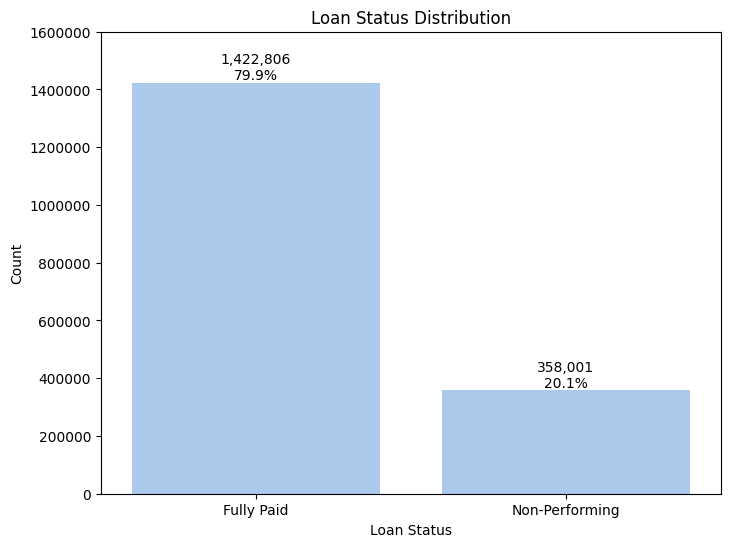

In [44]:
# Plot the distribution of loan_status
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(df['loan_status'].unique())]
print(colors)
plt.gca().set_prop_cycle('color', colors)

sns.countplot(x='loan_status', data=df_pruned)
# Add title and labels
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Show y-axis in millions
plt.ticklabel_format(style='plain', axis='y')

# Set y-axis top to 1.5M
plt.ylim(0, 1600000)

# Add percentage and count on top of each bar
for i in df_pruned['loan_status'].unique():
    if i is not np.nan:
        count = df_pruned['loan_status'].value_counts()[i]
        pct_string = f'{count:,}\n{np.round(count/len(df_pruned)*100, 2)}%'
        plt.text(i, count, pct_string, ha='center', va='bottom')

plt.savefig('./output/new_loan_status_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Save the cleaned data to a new csv file
df_pruned.to_csv('./output/cleaned_loan_data.csv', index=False)

## YData Report

In [46]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_pruned, title="Data Profiling Report After Initial Cleaning")
profile.to_file("./output/data_profile_report_after_cleaning.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:66: UserWarning:

There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'NC'')



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]